## Udacity Nano degree - Capstone Project
### Visualization

The following tries to visualize the model we use to classify the chest xray images. Types of visualization include:

* Image occlusion
* Initial layer weight visualization
* Activation visualization

The code is modified from [here](https://github.com/waleedka/cnn-visualization/blob/master/cnn_visualization.ipynb)

##### Import libraries and set random state

In [1]:
##### Import needed libraries
from numpy.random import seed
seed(1)

In [49]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import skimage.filters
import keras
from keras import backend as K
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
# Allow graph embeding in notebook
%matplotlib inline

### Helper methods

In [116]:
def tensor_summary(tensor):
    """Display shape, min, and max values of a tensor."""
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

    
def normalize(image):
    """Takes a tensor of 3 dimensions (height, width, colors) and normalizes it's values
    to be between 0 and 1 so it's suitable for displaying as an image."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)


def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    """
    images: A list of images. I can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11, 11 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1

def path_to_tensor(img_path, target_width, target_height):
    img = image.load_img(img_path, target_size=(target_width, target_height))
    # convert PIL.Image.Image type to 3D tensor with shape (target_width, target_height, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, target_width, target_height, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def get_top_model(data, num_classes, dr=.2):
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=data.shape[1:]))
    model.add(Dropout(dr))
    model.add(Dense(num_classes, activation='softmax'))
    return model        

In [114]:
InceptionResV2 = InceptionResNetV2(weights='imagenet', include_top=False)
InceptionResV2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_610 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_610 (BatchN (None, None, None, 3 96          conv2d_610[0][0]                 
__________________________________________________________________________________________________
activation_610 (Activation)     (None, None, None, 3 0           batch_normalization_610[0][0]    
__________________________________________________________________________________________________
conv2d_611

##### Load a random image for visualization

Use keras image processing to load the image and convert it to image array which is used for prediction. Save the image array using skimage.imsave for later image manipulation such as applying heat map mask

shape: (299, 299, 3)  min: 0.0  max: 255.0


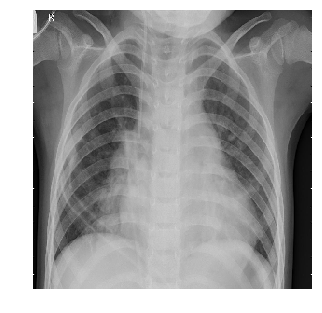

In [201]:
img_test_path = 'visualization/BACTERIA0001.jpeg'
img = image.load_img(img_test_path, target_size=(299, 299))
img_data = image.img_to_array(img)
tensor_summary(img_data)
skimage.io.imsave("test.png", img_data.astype(np.uint8))
image_test1 = skimage.io.imread("test.png")
display_images([image_test1], cols=2)

##### Predict

In [180]:
saved_model_weights_path = 'saved_weights/InceptionResNetV2/299_299/model.h5'
result_output = ['NORMAL.', 'Bacterial Pneumonia', 'Viral Pneumonia']
tensor = path_to_tensor(img_test_path, target_width=299, target_height=299)
tensor_input = preprocess_input(tensor)
bottleneck_feature = InceptionResV2.predict(tensor_input)
cnn_model = get_top_model(bottleneck_feature, 3)
cnn_model.load_weights(saved_model_weights_path)
predicted_vector = cnn_model.predict(bottleneck_feature) 
predict_prob = np.max(predicted_vector) * 100
label_index = np.argmax(predicted_vector)

print ('The result is {0} with a probability of {1:.2f}%'.format(result_output[label_index], predict_prob))


The result is Bacterial Pneumonia with a probability of 89.29%


##### Heat map

In [183]:
step = 40
heatmap_x = []
for row in range(0, img_data.shape[0], step):
    for col in range(0, img_data.shape[1], step):
        new_image = img_data.copy()
        # Add a square patch. Using a bright color here to make it easier to see.
        new_image[row:row+step, col:col+step] = [250,128,128]
        heatmap_x.append(new_image)
heatmap_x = np.stack(heatmap_x)
heatmap_x.shape

(64, 299, 299, 3)

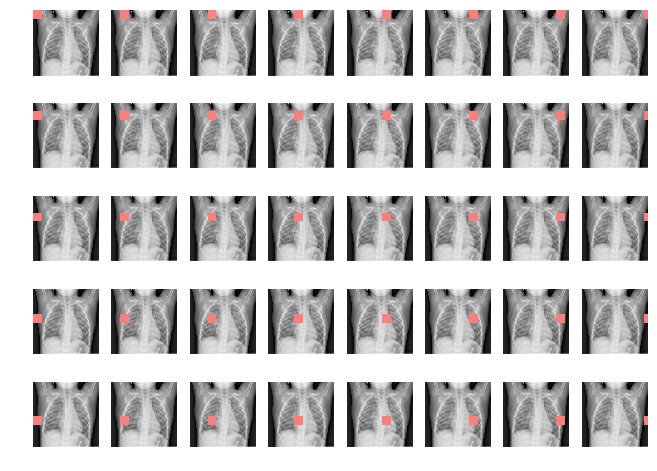

In [147]:
display_images(heatmap_x[:40], cols=8)

In [184]:
features = InceptionResNetV2Model.predict(preprocess_input(heatmap_x.astype(np.float32)))
heatmap_y = cnn_model.predict(features)
tensor_summary(heatmap_y)

shape: (64, 3)  min: 4.417466641370993e-07  max: 0.9580351114273071


In [186]:
probs = heatmap_y[:, label_index]
tensor_summary(probs)

shape: (64,)  min: 0.6028827428817749  max: 0.9580351114273071


In [188]:
heatmap = (probs.max() - probs) / (probs.max()-probs.min())
heatmap = np.reshape(heatmap, (8, 8))
tensor_summary(heatmap)

shape: (8, 8)  min: 0.0  max: 1.0


shape: (8, 8)  min: 0.0  max: 1.0


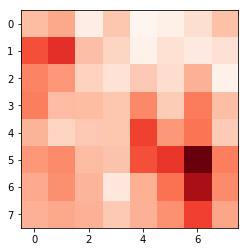

In [189]:
tensor_summary(heatmap)
_ = plt.imshow(heatmap, cmap=plt.cm.Reds)

##### Apply the heatmap maks on the original image

This allows us to see the location that really matters to the final prediction

/anaconda3/envs/capstone/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/envs/capstone/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


shape: (299, 299, 3)  min: 0.0  max: 125.87815553209067


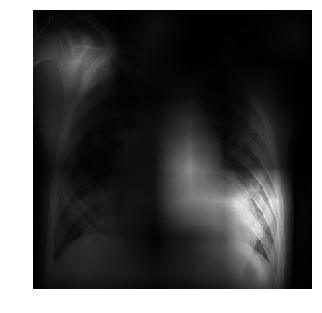

In [195]:
def apply_mask(image, mask):
    # Resize mask to match image size
    mask = skimage.transform.resize(normalize(mask), image.shape[:2])[:,:,np.newaxis].copy()
    # Apply mask to image
    image_heatmap = image * mask
    tensor_summary(image_heatmap)
    display_images([image_heatmap], cols=2)


# Apply mask to image
apply_mask(image_test1, heatmap**2)

##### Visualize the weights

conv2d_610 is one of the first layer in InceptionResnetV2 model.


In [197]:
weights = InceptionResV2.get_layer("conv2d_610").get_weights()[0]
weights.shape, weights.min(), weights.max()

((3, 3, 3, 32), -1.3222755, 1.2175325)

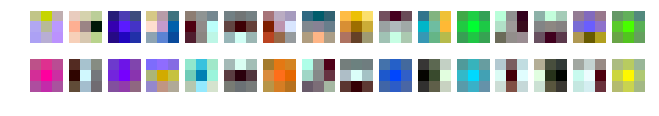

In [199]:

display_images([weights[:,:,::-1,i] for i in range(32)], cols=16, interpolation="none")

##### Visualize activations

In [200]:
def read_layer(model, x, layer_name):
    """Return the activation values for the specifid layer"""
    # Create Keras function to read the output of a specific layer
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=5):
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(10)], cols=cols)

shape: (1, 149, 149, 32)  min: -9.680535316467285  max: 7.531152248382568


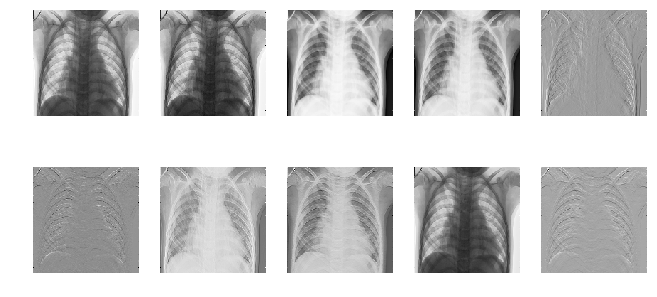

In [203]:
view_layer(InceptionResV2, tensor_input, "conv2d_610")

shape: (1, 35, 35, 320)  min: -13.364314079284668  max: 6.753915786743164


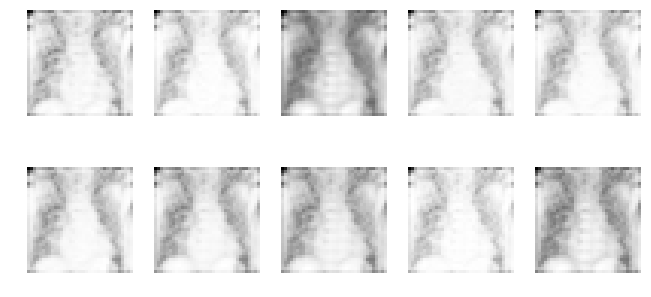

In [204]:
view_layer(InceptionResV2, tensor_input, "block35_1_conv")

shape: (1, 35, 35, 32)  min: -1.8254472017288208  max: 7.958603382110596
shape: (299, 299, 3)  min: 0.0  max: 186.92364036331014


/anaconda3/envs/capstone/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/envs/capstone/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


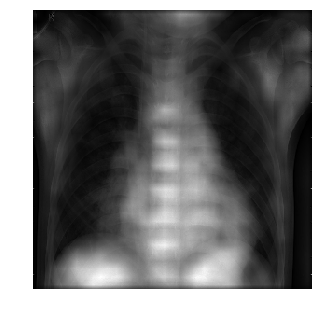

In [208]:
layer_mask1 = read_layer(InceptionResV2, tensor_input,'conv2d_622')
apply_mask(image_test1, layer_mask1[:,:,0])

shape: (1, 35, 35, 320)  min: -13.364314079284668  max: 6.753915786743164
shape: (299, 299, 3)  min: 0.0  max: 194.88664776527838


/anaconda3/envs/capstone/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/envs/capstone/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


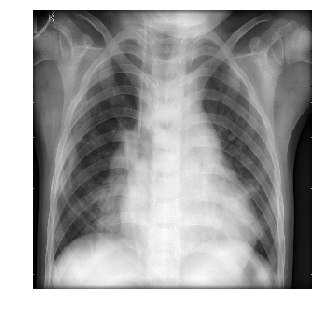

In [207]:
a = read_layer(InceptionResV2, tensor_input, "block35_1_conv")
apply_mask(image_test1, a[:,:,0])